In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

In [58]:
data = np.loadtxt('data/kalman_cartesian_data.dat')
data_relative = np.loadtxt('data/kalman_relative_data.dat')
kontrola = np.loadtxt('data/kalman_cartesian_kontrola.dat')

In [59]:
# Surovi podatki
t = data[:,0]
x = data[:,1]
y = data[:,2]
vx = data[:,3]
vy = data[:,4]
ax = data[:,5]
ay = data[:,6]

# Surovi relative podatki
t = data_relative[:,0]
x_rel = data_relative[:,1]
y_rel = data_relative[:,2]
at = data_relative[:,3]
ar = data_relative[:,4]

# Kontrilni podatki
t_kontrola = kontrola[:,0]
x_kontrola = kontrola[:,1]
y_kontrola = kontrola[:,2]
vx_kontrola = kontrola[:,3]
vy_kontrola = kontrola[:,4]

In [60]:
z = np.column_stack((x, y, vx, vy)) # meritve
z_rel = np.column_stack((x_rel, y_rel, at, ar))
z_kontrola = np.column_stack((x_kontrola, y_kontrola, vx_kontrola, vy_kontrola))

# Časovni korak
del_t = t[1] - t[0]

# Napake meritev
sigma_xy = 25. # m
sigma_a = 0.05 # m/s^2
sigma_v = 0.01 * np.sqrt(vx**2 + vy**2) # m/s
sigma_v = np.where(sigma_v < 1./3.6, 1./3.6, sigma_v) # m/s Popravimo minimalno napako na 1 km/h

In [61]:
# Kalmanov filter

step_x = 1.
step_v = 1.

x_prior = np.zeros_like(z) # prior estimate za lego in hitrost
x_prior[0] = z[0] # Začetno stanje
P_prior = np.zeros((len(z), len(z[0]), len(z[0]))) # prior estimate za kovariančno matriko
P_prior[0] = np.diag((sigma_xy, sigma_xy, sigma_v[0], sigma_v[0])) # Začetno stanje

x_post = np.zeros_like(z) # post estimate za lego in hitrost
x_post[0] = z[0] # Začetno stanje
P_post = np.zeros((len(z), len(z[0]), len(z[0]))) # post estimate za konariančno matriko
P_post[0] = np.diag((sigma_xy, sigma_xy, sigma_v[0], sigma_v[0])) # Začetno stanje

x_prior_rel = np.zeros_like(z) # prior estimate za lego in hitrost
x_prior_rel[0] = np.array([z_rel[0][0], z_rel[0][1], 0.001, 0.001]) # Začetno stanje
P_prior_rel = np.zeros((len(z), len(z[0]), len(z[0]))) # prior estimate za kovariančno matriko
P_prior_rel[0] = np.diag((sigma_xy, sigma_xy, 1000., 1000.)) # Začetno stanje

x_post_rel = np.zeros_like(z) # post estimate za lego in hitrost
x_post_rel[0] = np.array([z_rel[0][0], z_rel[0][1], 0.001, 0.001]) # Začetno stanje
P_post_rel = np.zeros((len(z), len(z[0]), len(z[0]))) # post estimate za konariančno matriko
P_post_rel[0] = np.diag((sigma_xy, sigma_xy, 1000., 1000.)) # Začetno stanje

for i in range(len(z)-1):

    F = np.array([ # Opiše dinamiko
        [1., 0., del_t, 0.   ],
        [0., 1., 0.   , del_t],
        [0., 0., 1.   , 0.   ],
        [0., 0., 0.   , 1.   ]
    ])
    Q = np.diag((sigma_a**2 * del_t**4 / 4., sigma_a**2 * del_t**4 / 4., sigma_a**2 * del_t**2, sigma_a**2 * del_t**2))
    R = np.diag((sigma_xy**2, sigma_xy**2, sigma_v[i]**2, sigma_v[i]**2))
    H = np.diag((float(i%step_x == 0.), float(i%step_x == 0.), 0., 0.))

    # Katerzično
    c = np.array([ax[i]*del_t**2 / 2., ax[i]*del_t**2 / 2., ax[i]*del_t, ay[i]*del_t])

    # Relativno
    u = np.array([at[i]*del_t**2 / 2., ar[i]*del_t**2 / 2., at[i]*del_t, ar[i]*del_t])
    vx_rel = x_post_rel[i][2]
    vy_rel = x_post_rel[i][3]
    v = np.sqrt(vx_rel**2 + vy_rel**2)
    B = np.array([
        [vx_rel/v, -vy_rel/v, 0.      , 0.       ],
        [vy_rel/v, vx_rel/v , 0.      , 0.       ],
        [0., 0.             , vx_rel/v, -vy_rel/v],
        [0., 0.             , vy_rel/v, vx_rel/v ]
    ])
    c_rel = np.dot(B, u)

    # Katerzično
    x_prior[i+1] = np.dot(F, x_post[i]) + c
    P_prior[i+1] = np.dot(F, np.dot(P_post[i], F.T)) + Q

    K = np.dot(np.dot(P_prior[i+1], H.T), np.linalg.inv(np.dot(np.dot(H, P_prior[i+1]), H.T) + R))
    x_post[i+1] = x_prior[i+1] + np.dot(K, (z[i+1] - np.dot(H, x_prior[i+1])))
    P_post[i+1] = np.dot((np.diag((1.,1.,1.,1.)) - np.dot(K, H)), P_prior[i+1])

    # Relativno
    x_prior_rel[i+1] = np.dot(F, x_post_rel[i]) + c_rel
    P_prior_rel[i+1] = np.dot(F, np.dot(P_post_rel[i], F.T)) + Q

    K_rel = np.dot(np.dot(P_prior_rel[i+1], H.T), np.linalg.inv(np.dot(np.dot(H, P_prior_rel[i+1]), H.T) + R))
    x_post_rel[i+1] = x_prior_rel[i+1] + np.dot(K_rel, (z_rel[i+1] - np.dot(H, x_prior_rel[i+1])))
    P_post_rel[i+1] = np.dot((np.diag((1.,1.,1.,1.)) - np.dot(K_rel, H)), P_prior_rel[i+1])

In [62]:
print(x_rel)

[5.74643616e+00 3.80523729e+00 8.02125142e+00 ... 2.71292034e+04
 2.71421395e+04 2.71536648e+04]


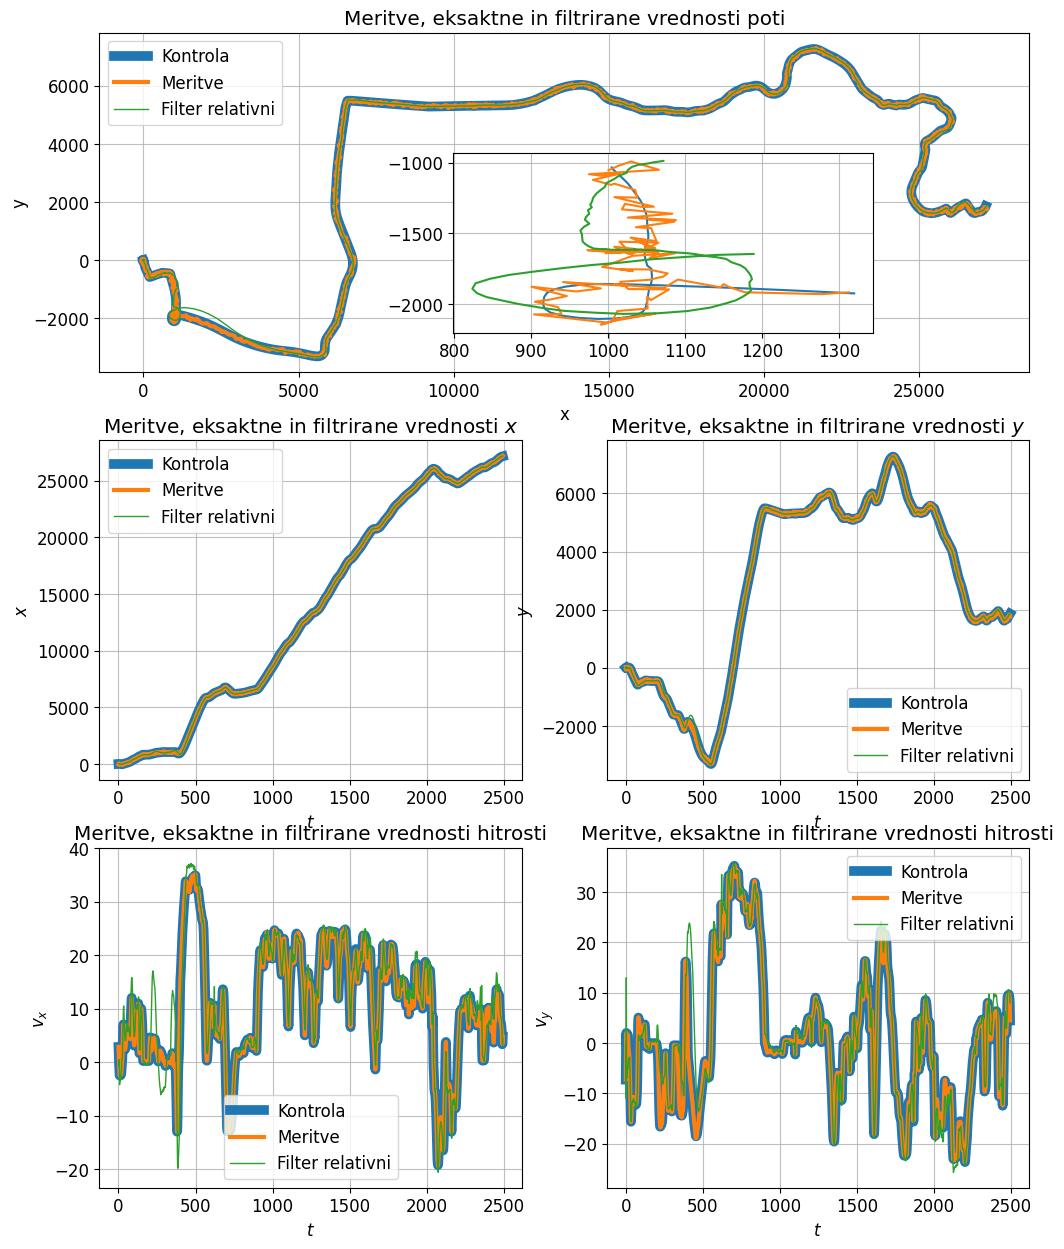

In [63]:
fig = plt.figure(figsize=(12, 15))

ax = fig.add_subplot(3, 2, (1,2))
ax.grid(alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Meritve, eksaktne in filtrirane vrednosti poti')
ax.plot(z_kontrola[:,0], z_kontrola[:,1], label='Kontrola', linewidth=7)
ax.plot(z[:,0], z[:,1], label='Meritve', linewidth=3)
ax.plot(x_post_rel[:,0], x_post_rel[:,1], label='Filter relativni', linewidth=1)
ax.legend()

ax_inset = fig.add_axes([0.42, 0.68, 0.35, 0.12])
ax_inset.grid(alpha=0.8)
ax_inset.plot(z_kontrola[:,0][145:235], z_kontrola[:,1][145:235], label='Kontrola')
ax_inset.plot(z[:,0][145:235], z[:,1][145:235], label='Meritve')
ax_inset.plot(x_post_rel[:,0][145:235], x_post_rel[:,1][145:235], label='Filter relativni')

ax = fig.add_subplot(3, 2, 3)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti $x$')
ax.plot(t_kontrola, z_kontrola[:,0], label='Kontrola', linewidth=7)
ax.plot(t, z[:,0], label='Meritve', linewidth=3)
ax.plot(t, x_post_rel[:,0], label='Filter relativni', linewidth=1)
ax.legend()

ax = fig.add_subplot(3, 2, 4)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$y$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti $y$')
ax.plot(t_kontrola, z_kontrola[:,1], label='Kontrola', linewidth=7)
ax.plot(t, z[:,1], label='Meritve', linewidth=3)
ax.plot(t, x_post_rel[:,1], label='Filter relativni', linewidth=1)
ax.legend()

ax = fig.add_subplot(3, 2, 5)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_x$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti hitrosti')
ax.plot(t_kontrola, z_kontrola[:,2], label='Kontrola', linewidth=7)
ax.plot(t, z[:,2], label='Meritve', linewidth=3)
ax.plot(t, x_post_rel[:,2], label='Filter relativni', linewidth=1)
ax.legend()

ax = fig.add_subplot(3, 2, 6)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_y$')
ax.set_title(r'Meritve, eksaktne in filtrirane vrednosti hitrosti')
ax.plot(t_kontrola, z_kontrola[:,3], label='Kontrola', linewidth=7)
ax.plot(t, z[:,3], label='Meritve', linewidth=3)
ax.plot(t, x_post_rel[:,3], label='Filter relativni', linewidth=1)
ax.legend()

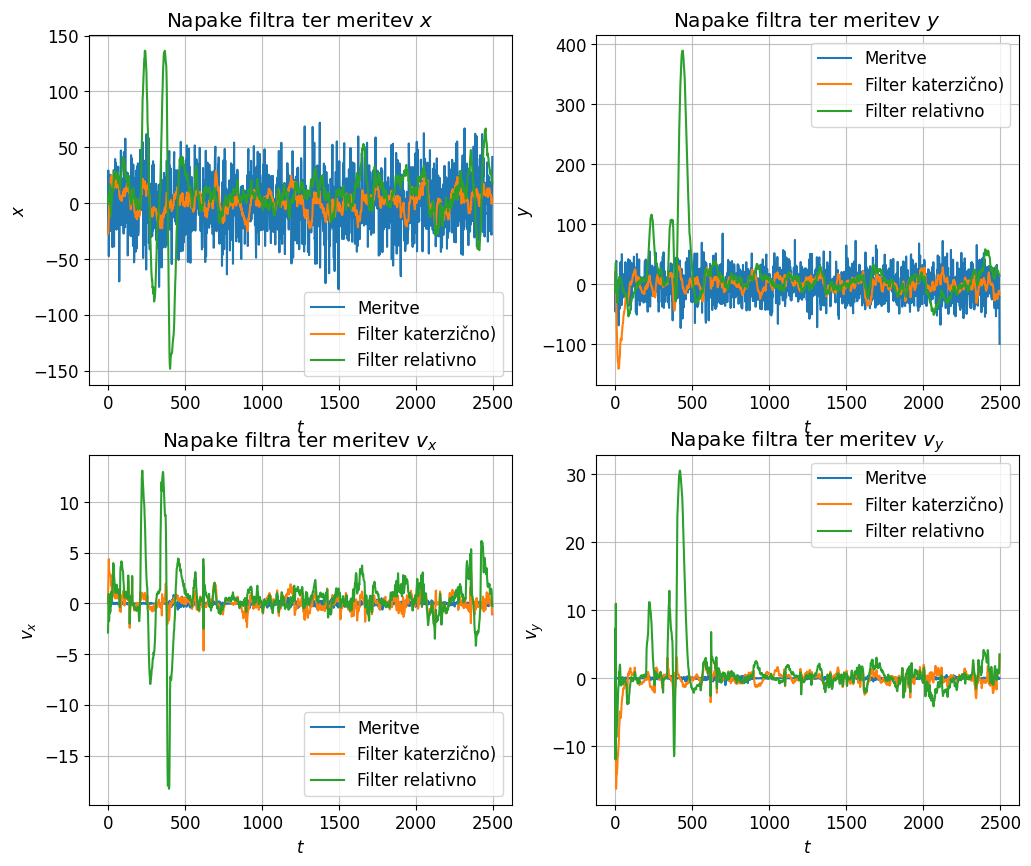

In [64]:
fig = plt.figure(figsize=(12, 10))

ax = fig.add_subplot(2, 2, 1)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_title(r'Napake filtra ter meritev $x$')
ax.plot(t, z[:,0]-z_kontrola[:,0], label='Meritve')
ax.plot(t, x_post[:,0]-z_kontrola[:,0], label='Filter katerzično)')
ax.plot(t, x_post_rel[:,0]-z_kontrola[:,0], label='Filter relativno')
ax.legend()

ax = fig.add_subplot(2, 2, 2)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$y$')
ax.set_title(r'Napake filtra ter meritev $y$')
ax.plot(t, z[:,1] - z_kontrola[:,1], label='Meritve')
ax.plot(t, x_post[:,1] - z_kontrola[:,1], label='Filter katerzično)')
ax.plot(t, x_post_rel[:,1] - z_kontrola[:,1], label='Filter relativno')
ax.legend()

ax = fig.add_subplot(2, 2, 3)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_x$')
ax.set_title(r'Napake filtra ter meritev $v_x$')
ax.plot(t, z[:,2] - z_kontrola[:,2], label='Meritve')
ax.plot(t, x_post[:,2] - z_kontrola[:,2], label='Filter katerzično)')
ax.plot(t, x_post_rel[:,2] - z_kontrola[:,2], label='Filter relativno')
ax.legend()

ax = fig.add_subplot(2, 2, 4)
ax.grid(alpha=0.8)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$v_y$')
ax.set_title(r'Napake filtra ter meritev $v_y$')
ax.plot(t, z[:,3] - z_kontrola[:,3], label='Meritve')
ax.plot(t, x_post[:,3] - z_kontrola[:,3], label='Filter katerzično)')
ax.plot(t, x_post_rel[:,3] - z_kontrola[:,3], label='Filter relativno')
ax.legend()

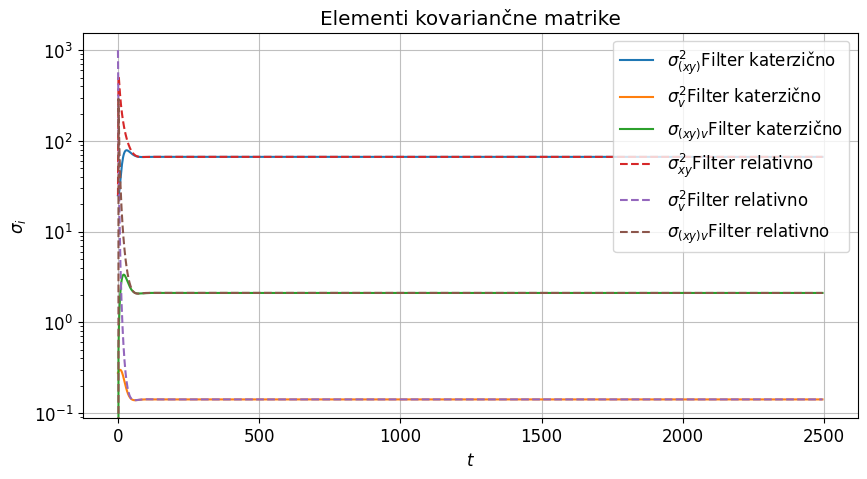

In [65]:
# Kovariančna matrika

sig_xy105 = P_post[:,0,0]
sig_v105 = P_post[:,2,2]
sig_vxy105 = P_post[:,1,3]
sig_xy11 = P_post_rel[:,0,0]
sig_v11 = P_post_rel[:,2,2]
sig_vxy11 = P_post_rel[:,1,3]

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.set_title(r'Elementi kovariančne matrike')
ax.set_ylabel(r'$\sigma_{i}$')
ax.set_xlabel(r'$t$')
ax.grid(alpha=0.8)
ax.plot(t, sig_xy105, label=r'$\sigma_{(xy)}^2$Filter katerzično')
ax.plot(t, sig_v105, label=r'$\sigma_{v}^2$Filter katerzično')
ax.plot(t, sig_vxy105, label=r'$\sigma_{(xy)v}$Filter katerzično')
ax.plot(t, sig_xy11, label=r'$\sigma_{xy}^2$Filter relativno', ls='--')
ax.plot(t, sig_v11, label=r'$\sigma_{v}^2$Filter relativno', ls='--')
ax.plot(t, sig_vxy11, label=r'$\sigma_{(xy)v}$Filter relativno', ls='--')
ax.set_yscale('log')
ax.legend()